# Invoice Revenue Forecasting Flow
Steps:
1. **Data Gathering** - Reading the Billing and Opportunity data from the HANA database
2. **Billing data aggregation** - Aggregating the Billing database data into monthly, quarterly and daily revenues.
3. **Opportunity data wrangling** - categorizing and string indexing the column values into numerical values.
4. **Opportunity data cleaning** - Selecting required and necessary columns from the opportunity dataset.
5. **Opportunity data modeling** - Separating the data into test and training according to the algorithm and training a decision treee model for classification with the training data.
6. **Opportunity data predictive analysis** - Predicting and classifying the opportunity dataset status and joining those values with the existing prepared dataset according to the logic presented in the algorithm.
7. **Exogenous variable preparation** - Applying the transformation on the aggregated standard deviation values from the classification result.
8. **Billing data diagnostics** - Identifying and handling the outlier. Testing the data characteristics. 
9. **Time series modeling** - Applying the SARIMAX model on the monthly aggregated revenue with multiple combinations of parameters. Choosing the model with the lowest AIC.
10. **Time series model evaluation** - Assessing the SARIMAX model with evaluation metrics.
11. **Time series model prediction** - Predicting the our-sample and in-sample revenue values.
12. **Final result aggregation** - Aggregating the three months out-sample prediction into the quarterly revenue value.


## Step: 0
Import Necessary Libraries

In [ ]:
import sys
import pyodbc
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import statsmodels.api as sm
import matplotlib
from numpy import sqrt
from numpy import log
import sqlite3
from sklearn import metrics
import numpy as np
from scipy.stats import boxcox
from pandas.tseries.offsets import MonthEnd, MonthBegin

## Step: 1.1

Reading data from Billing and Opportunity dataset.

In [ ]:
conn = pyodbc.connect('DSN=HANA')
cursor = conn.cursor()

orders = """select * from DATA_TMP.BILLING_DATA_20201019"""
sales = """select * from DATA_TMP.OPPORTUNITIES_DATA_20201019"""
table_all_billing = pd.read_sql(orders,conn)

table_all_sales = pd.read_sql(sales,conn)


## Step: 1.2 
Converting the opportunity sales dataset into pandas dataframe.

In [ ]:
df_sales = pd.DataFrame(table_all_sales,columns=['fDivisionView','fType','ForecastFiscalMonth','MarketingFunnelType','GeoSubRegion','ClosingStatus','UnWeightedkUSD'])
df_sales=df_sales.fillna(0)

## Step: 1.3
Converting the billing dataset into pandas dataframe.

In [ ]:
data_frame = pd.DataFrame(table_all_billing)
month_attr = 'DocumentMonth'

## Step: 1.4 Inputs
Inputs requred to define the objective of the prediction.
1. date_attr = The date column name in the billing dataset
2. revenue_attr = The revenue column name in the billing dataset
3. grouping_attr = if it is not None then it will have the value of the specific product line / marketing channel / region column for those specific predictions.
4. search_attr = if it is not None then it will have the value of the specific value in the grouping_attr column for the specific predicitions.

In [ ]:
grouping_attr = None
search_attr = None


# Only thing needed to be changed
# Please change input here
date_attr = 'BillingDocumentDate'
revenue_attr = 'BillingLegalNetPlanRateUSD'
# grouping_attr = 'RestatedChannelType'
# search_attr = 'DIRECT'
analysis = 'monthly' # monthly
decomposition_model = 'multiplicative'

## Step: 1.5 
Transformation type for the Exogenous variable.

In [ ]:
exog_transformation = None

# Exog Variable Transformation
exog_transformation = 'boxcox' #log, boxcox, sqrt

## Step 2.1 
Functions for billing data aggregation into monthly, quarterly or daily revenue.

In [ ]:
def convert_to_quarterly(input_df, revenue_attr, month_attr):
    """Aggregates 3 months of data to a quarterly value."""
    df = input_df.copy()
    df = df.set_index(month_attr)
    agg_columns = [revenue_attr]
    extra_cols = [x for x in df.columns if x not in agg_columns]
    df_out = df.resample("QS-NOV")[agg_columns].sum()
    df_out.index = df_out.index - MonthBegin(0)
    df_out[extra_cols] = df[extra_cols]
    return df_out


def all_aggregation(data_frame, date_attr, revenue_attr, month_attr,  grouping_attr=None, search_attr=None):
    data_frame[date_attr] = pd.to_datetime(data_frame[date_attr], format='%Y-%m-%d')
    aggregated_date_cond = data_frame.groupby(date_attr).agg({revenue_attr : 'sum'})
    if grouping_attr is not None:
        aggregated_date_cond = data_frame.groupby([grouping_attr, date_attr]).agg({revenue_attr : 'sum'})
    aggregated_date_cond = aggregated_date_cond.reset_index()
    aggregated_date = aggregated_date_cond
    if grouping_attr is not None:
        aggregated_date = aggregated_date.loc[aggregated_date[grouping_attr] == search_attr]
        aggregated_date = aggregated_date.drop(columns=grouping_attr)
    aggregated_date_for_month = aggregated_date.copy()
    aggregated_date[month_attr] = aggregated_date[date_attr]
    aggregated_date = aggregated_date.drop(columns=date_attr)
    aggregated_date_for_month[month_attr] = aggregated_date_for_month[date_attr] + pd.offsets.MonthBegin(1) - pd.offsets.MonthBegin(1)
    aggregated_month = aggregated_date_for_month.groupby(month_attr).agg({revenue_attr : 'sum'})
    aggregated_month = aggregated_month.reset_index()
    aggregated_quarter = convert_to_quarterly(aggregated_month, revenue_attr, month_attr)
    aggregated_quarter = aggregated_quarter.reset_index()
    
    return aggregated_date, aggregated_month, aggregated_quarter
aggregated_date, aggregated_month, aggregated_quarter = all_aggregation(data_frame, date_attr, revenue_attr, month_attr, grouping_attr, search_attr)

## Step 3: Opportunity Data Wrangling 


1. Convert Qualitative variables to categorical values (0s and 1s)
2. Performing String Indexing on all the quantitative variables (ClosingStatus, ForecastFiscalMonth)
3. Fill all the none and null values for all variables in consideration with zeroes. 

In [ ]:
def cat_to_dummy(data,list):
    import pandas as pd
    for i in list:
        data=pd.concat([data, pd.get_dummies(data[i], prefix = i)], axis = 1)
    data=data.drop(list, axis = 1)
    return data.copy()

In [ ]:
df_sales_dummy =cat_to_dummy(df_sales,['fDivisionView','fType','MarketingFunnelType','GeoSubRegion'])

df_sales_dummy['ClosingStatus_index'] = df_sales_dummy.groupby('ClosingStatus').ngroup()
df_sales_dummy['ForecastFiscalMonth_index'] = df_sales_dummy.groupby('ForecastFiscalMonth').ngroup()
df_sales_dummy = df_sales_dummy.sort_values(by='ForecastFiscalMonth_index',ascending=True)
df_sales_dummy=df_sales_dummy.fillna(0)


In [ ]:
test_frame = df_sales_dummy.copy()
test_frame['UnWeightedkUSD'].replace('None', np.nan, inplace=True)
test_frame=test_frame.fillna(0)

## Step 4: Opportunity Data Cleaning

Selecting the required columns and dropping the unrequired columns

In [ ]:
test_frame_not_open = test_frame.loc[test_frame['ClosingStatus'] != 'Open']
test_frame_open = test_frame.loc[test_frame['ClosingStatus'] == 'Open']
test_frame_won = test_frame.loc[test_frame['ClosingStatus'] == 'Won']
df1= test_frame_not_open.drop(['ClosingStatus', 'ForecastFiscalMonth'], axis=1)
test_frame_open= test_frame_open.drop(['ClosingStatus', 'ForecastFiscalMonth'], axis=1)
test_frame_won1 = test_frame_won.drop(['ClosingStatus', 'ForecastFiscalMonth'], axis=1)
df1 = df1.apply(pd.to_numeric)
test_frame_open = test_frame_open.apply(pd.to_numeric)
test_frame_won1 = test_frame_won1.apply(pd.to_numeric)

## Step 5: Opportunity Data Modelling 

1. Create three datasets depending on the "ClosingStatus" value to use as training and testing data.
2. Training data - Dataset not containing "ClosingStatus" = Open
3.Testing data -  Dataset containing only "ClosingStatus" = Open
4. Training and testing data to be used for predicting "ClosingStatus" = Won

In [ ]:
# MoneyCast Sampling 
import pandas as pd 

x_train = df1.drop(['ClosingStatus_index'], axis = 1) 
y_train = df1['ClosingStatus_index'] 

x_test_open = test_frame_open.drop(['ClosingStatus_index'], axis = 1)
y_test_open = test_frame_open['ClosingStatus_index']
    
print('Class Distribution:',y_test_open.value_counts()/len(y_test_open))

Class Distribution: 3    1.0
Name: ClosingStatus_index, dtype: float64


## Step 6 : Opportunity Data Predictive Analysis 

1. Using Decision Tree model to classify and predict ClosingStatus = Won using training and testing data
2. Filtering the predictive dataset for ClosingStatus = Won and combining with the original dataset containing ClosingStatus = Won
3. Using the combined dataset of ClosingStatus = Won we aggregate the data by Month for standard deviation and mean

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
  
model = DecisionTreeClassifier() 
dt = GridSearchCV(model, param_grid={"max_depth":[1,2,3,4,5,6,7,8,9]}) 
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test_open)

In [ ]:
x_test_open = x_test_open.reset_index()
x_test_open = x_test_open.drop(columns ='index')
won_dataframe = pd.DataFrame()
count=0
for index, status in enumerate(y_pred_dt):
    if status == 5:
        count = count + 1
        won_dataframe = won_dataframe.append(x_test_open.iloc[index])

In [ ]:
master_won_table = won_dataframe.append(test_frame_won1,sort=False)

## Step 7: Exogenous Variable Preparation

1. Using the standard deviation values from the aggregated dataset
2. Applying transformation on the standard deviation values to be used as exogenous variables in the SARIMA Model

In [ ]:
df_agg_month = master_won_table.groupby('ForecastFiscalMonth_index').agg({'UnWeightedkUSD':[pd.Series.std]})

In [ ]:
# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def model_selection(month_attr):
    analysis_sel = 0
    if analysis == 'daily':
        analysis_sel = 365
        df = aggregated_date
    elif analysis == 'monthly':
        analysis_sel = 12
        df = aggregated_month
    else:
        analysis_sel = 4
        df = aggregated_quarter
    return df, analysis_sel


def exog_transformation_select(exog_variable_list, out_sample_exog, exog_transformation, exog_boxcox_lambda):
    if exog_transformation == 'boxcox':
        exog_variable_list = boxcox(exog_variable_list, lmbda=exog_boxcox_lambda)
        out_sample_exog = boxcox(out_sample_exog, lmbda=exog_boxcox_lambda)
    elif exog_transformation == 'log':
        exog_variable_list = log(exog_variable_list)
        out_sample_exog = log(out_sample_exog)
    elif exog_transformation == 'sqrt':
        exog_variable_list = sqrt(exog_variable_list)
        out_sample_exog = sqrt(out_sample_exog)
    return exog_variable_list, out_sample_exog

In [ ]:
selected_frame, analysis_sel = model_selection(month_attr)

In [ ]:
in_sample_length = len(selected_frame.index)
in_sample_exog = df_agg_month.loc[:in_sample_length - 1]
exog_variable_list = in_sample_exog[('UnWeightedkUSD', 'std')].tolist()
out_sample_exog_df = df_agg_month.loc[in_sample_length:]
out_sample_exog_df = out_sample_exog_df.fillna(0)
out_sample_exog = out_sample_exog_df[('UnWeightedkUSD', 'std')].tolist()
out_sample_exog = out_sample_exog[:int(len(exog_variable_list)*0.3)]

## Step 8.1:

Identifying and handling the Outlier.

In [ ]:
data_mean = selected_frame[revenue_attr].mean()
data_stdev = selected_frame[revenue_attr].std()

In [ ]:
z_score_frame = selected_frame.copy()
z_score_frame['ZScore'] = ((z_score_frame[revenue_attr] - data_mean)/data_stdev)

In [ ]:
outlier_index = []
for index, row in z_score_frame.iterrows():
    if(abs(row['ZScore']) > 3.00):
        outlier_index.append(index)

In [ ]:
def sarimax_model_training(y, exog_variable_list, out_sample_exog, exog_transformation):
    y = y.set_index([month_attr])
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], analysis_sel) for x in list(itertools.product(p, d, q))]
    minimum = 9223372036854775807
    min_param = 0
    min_param_seasonal = 0
    min_results = 0
    min_lambda = 0
    for exog_lambda in np.arange(0, 5.25, 0.25):
        exog_variable_list_temp, out_sample_exog_temp = exog_transformation_select(exog_variable_list, out_sample_exog, exog_transformation, exog_lambda)
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(endog=y, exog=exog_variable_list_temp, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False, trend='ct')
                    results = mod.fit()
                    if results.aic is not None and results.aic <= minimum:
                        minimum = results.aic
                        min_param = param
                        min_param_seasonal = param_seasonal
                        min_results = results.aic
                        min_lambda = exog_lambda
                except:
                    continue

    exog_variable_list_a, out_sample_exog_a = exog_transformation_select(exog_variable_list, out_sample_exog, exog_transformation, min_lambda)
    print('ARIMA{}x{}{} - AIC:{}'.format(min_param, min_param_seasonal, analysis_sel, min_results))
    mod = sm.tsa.statespace.SARIMAX(endog=y, exog=exog_variable_list_a,
                                    order=min_param,
                                    seasonal_order=min_param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False, trend='ct')
    results = mod.fit()
    return results, exog_variable_list_a, out_sample_exog_a
                      

In [ ]:
import warnings
warnings.filterwarnings("ignore")
outlier_normalization = selected_frame.copy()
outlier_normalized = selected_frame.copy()
for indexes in outlier_index:
    outlier_training = outlier_normalization[0: indexes]
    outlier_exog_insample = exog_variable_list[0: indexes]
    outlier_exog_outsample = exog_variable_list[indexes:]
    outlier_results, outlier_exog_list, outlier_out_sample_exog = sarimax_model_training(outlier_training, outlier_exog_insample, outlier_exog_outsample, exog_transformation)
    outlier_pred = outlier_results.get_forecast(steps=len(outlier_exog_outsample), exog=outlier_exog_outsample)
    outlier_forecast = outlier_pred.predicted_mean.to_frame()
    outlier_forecast = outlier_forecast.reset_index()
    outlier_normalized.loc[indexes, revenue_attr] = outlier_forecast[0][0]

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:270.50332742750106


## Step: 8.2
Decomposing the time series into level, trend, seasonality and noise components.

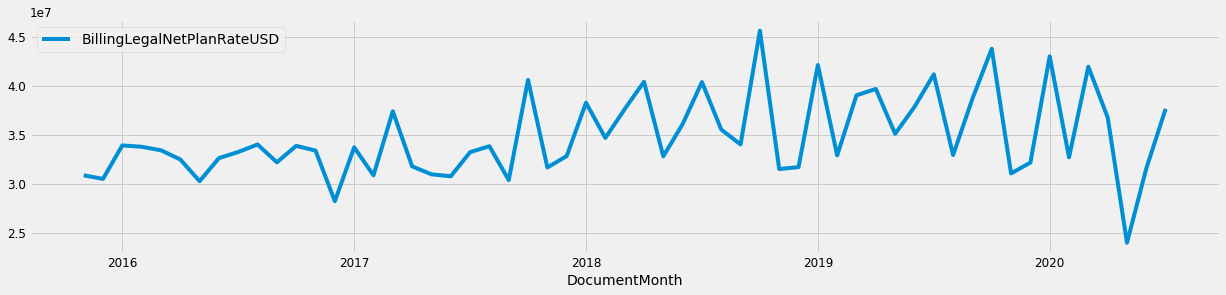

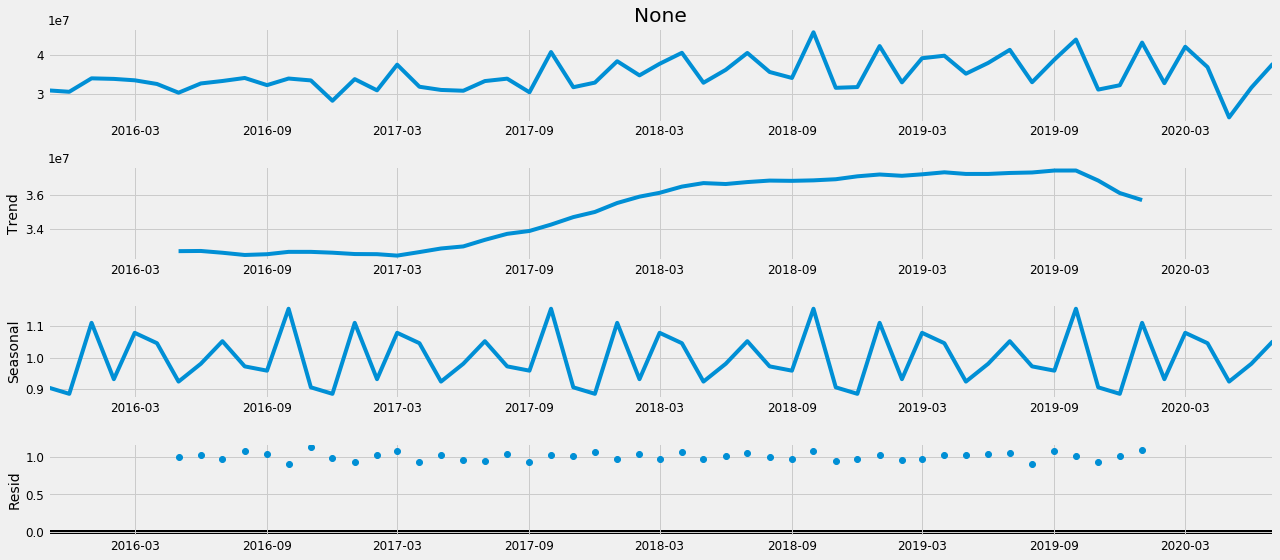

In [ ]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

y = outlier_normalized.copy()
y = y.set_index([month_attr])

y.plot(figsize=(19, 4))
plt.show()
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model=decomposition_model)
fig = decomposition.plot()
plt.show()

## Step: 8.3
Detecting stationary in time series using the Augmented Dickey-Fuller(ADF) test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

### Step 8.3.1
Applying the Augmented Dickey-Fuller(ADF) on the raw data.

In [ ]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

In [ ]:
stationary_test = y.copy()
ADF_test(stationary_test.BillingLegalNetPlanRateUSD,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.386
P-value = 0.589
Critical values :
	1%: -3.584828853223594 - The data is not stationary with 99% confidence
	5%: -2.9282991495198907 - The data is not stationary with 95% confidence
	10%: -2.6023438271604937 - The data is not stationary with 90% confidence


## Step 8.4
Detrending the raw data, then applying the Augmented Dickey-Fuller(ADF) on the detrend data.

 > Is the de-trended data stationary ?
Test statistic = -2.072
P-value = 0.256
Critical values :
	1%: -3.6327426647230316 - The data is not stationary with 99% confidence
	5%: -2.9485102040816327 - The data is not stationary with 95% confidence
	10%: -2.6130173469387756 - The data is not stationary with 90% confidence


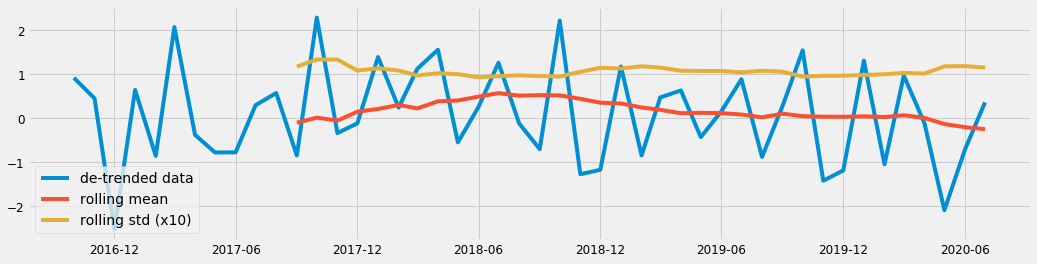

In [ ]:
# Detrending + ADF
y_detrend =  (stationary_test.BillingLegalNetPlanRateUSD - stationary_test.BillingLegalNetPlanRateUSD.rolling(window=12).mean())/stationary_test.BillingLegalNetPlanRateUSD.rolling(window=12).std()
test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

## Step: 8.5
Differencing the raw data, then applying the Augmented Dickey-Fuller(ADF) on the differencing data.

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.104
P-value = 0.713
Critical values :
	1%: -3.596635636000432 - The data is not stationary with 99% confidence
	5%: -2.933297331821618 - The data is not stationary with 95% confidence
	10%: -2.6049909750566895 - The data is not stationary with 90% confidence


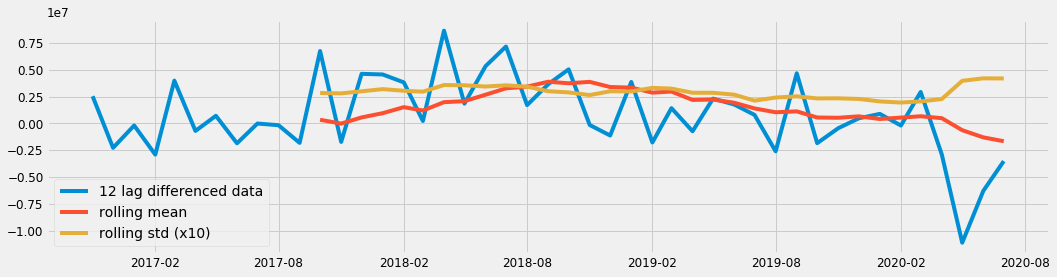

In [ ]:
# Differencing12
y_12_lag =  stationary_test.BillingLegalNetPlanRateUSD - stationary_test.BillingLegalNetPlanRateUSD.shift(12)
test_stationarity(y_12_lag,'12 lag differenced data')
ADF_test(y_12_lag,'12 lag differenced data')

## Step: 8.6
Applying the Augmented Dickey-Fuller(ADF) on the detrending and differencing data.

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -5.387
P-value = 0.000
Critical values :
	1%: -3.6461350877925254 - The data is  stationary with 99% confidence
	5%: -2.954126991123355 - The data is  stationary with 95% confidence
	10%: -2.6159676124885216 - The data is  stationary with 90% confidence


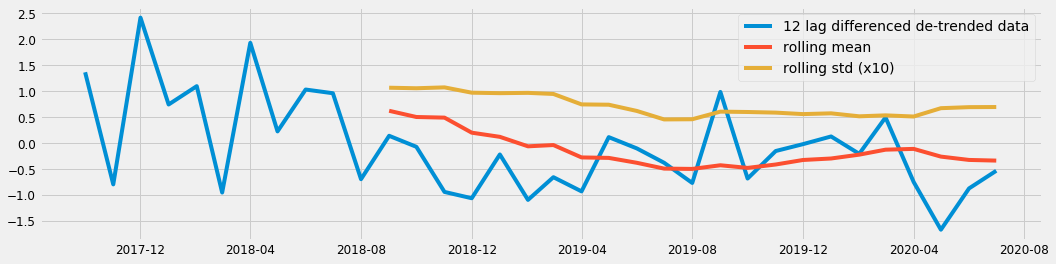

In [ ]:
# Detrending + Differencing 

y_12_lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12_lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12_lag_detrend,'12 lag differenced de-trended data')

## Step: 9.1
Applying the SARIMAX model on the monthly aggregated revenue with multiple combinations of parameters.
- The grid searching space for parameters(p,d,q)(P,Q,Q) is from 0 to 2. 
- The lambda of BoxCox transfromation ranges from 0 to 5
- Fitting a new SARIMAX model and using the AIC score to asses the overall quality of the model for each parameter combination. The lower the AIC score, the better the fit of the model
- Automatically choosing the model with the lowest AIC and the optimal lambda.

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], analysis_sel) for x in list(itertools.product(p, d, q))]
minimum = 9223372036854775807
min_param = 0
min_param_seasonal = 0
min_results = 0
min_lambda = 0
for exog_lambda in np.arange(0, 5.25, 0.25):
    exog_variable_list_temp, out_sample_exog_temp = exog_transformation_select(exog_variable_list, out_sample_exog, exog_transformation, exog_lambda)
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(endog=y, exog=exog_variable_list_temp, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False, trend='ct')
                results = mod.fit()
                if results.aic is not None and results.aic <= minimum:
                    minimum = results.aic
                    min_param = param
                    min_param_seasonal = param_seasonal
                    min_results = results.aic
                    min_lambda = exog_lambda
            except:
                continue

exog_variable_list_sarima, out_sample_exog_sarima = exog_transformation_select(exog_variable_list, out_sample_exog, exog_transformation, min_lambda)
print('ARIMA{}x{}{} - AIC:{}'.format(min_param, min_param_seasonal, analysis_sel, min_results))
mod = sm.tsa.statespace.SARIMAX(endog=y, exog=exog_variable_list_sarima,
                                order=min_param,
                                seasonal_order=min_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print("Minimum Transformation Lambda = ", min_lambda)
print(results.summary().tables[1])

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1008.7453896644371
Minimum Transformation Lambda =  0.0
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.075e+06   8.97e+05     -1.198      0.231   -2.83e+06    6.83e+05
ar.L1          0.0495      0.588      0.084      0.933      -1.103       1.202
ma.L1         -0.6751      0.463     -1.458      0.145      -1.583       0.233
ar.S.L12      -0.5942      0.251     -2.368      0.018      -1.086      -0.102
ma.S.L12       0.6184      0.507      1.220      0.223      -0.375       1.612
sigma2      1.113e+13      0.056      2e+14      0.000    1.11e+13    1.11e+13


## Step: 9.2
Visualzing the in-sample and out-sample forecasting.

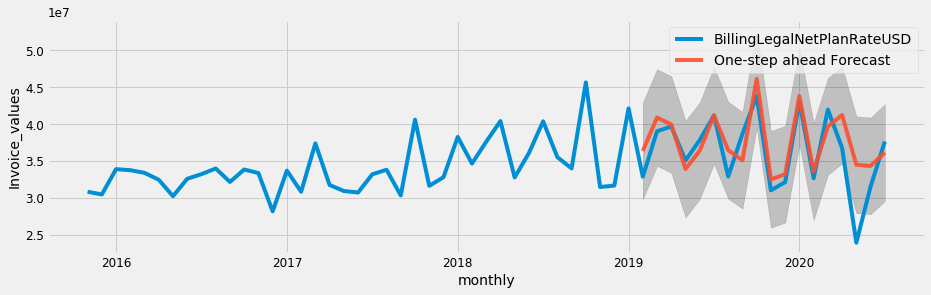

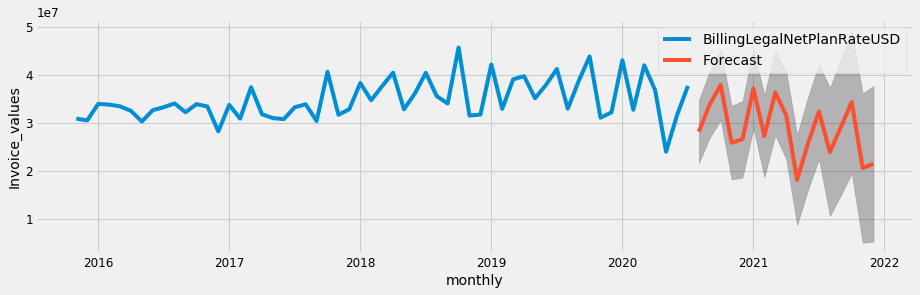

In [ ]:
start = y.copy()
start = start.reset_index()
start_val = start.iloc[int(len(start.index) * 0.7)][month_attr]
true_test = (start.iloc[int(len(start.index) * 0.7):]).copy()
pred = results.get_prediction(start=pd.to_datetime(start_val), exog=exog_variable_list_sarima[int(len(start.index) * 0.7):len(exog_variable_list_sarima) - 1], dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel(str(analysis))
ax.set_ylabel('Invoice_values')
plt.legend()
plt.show()


pred_uc = results.get_forecast(steps=int(len(start.index) * 0.3), exog=out_sample_exog_sarima[0:int(len(start.index) * 0.3)])

pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel(analysis)
ax.set_ylabel('Invoice_values')
plt.legend()
plt.show()

## Step 10
Assessing the SARIMAX model with evaluation metrics.
- **The top-left plot:** the distribution of model residuals over time. The residuals should to be distributed with zero-mean and no obvious seasonality.
- **The top-right plot:** the noramal distribution of model residuals. The red KDE line should follow closely with the yellow N(0,1) line, which is the standard notation for a normal distribution with mean 0 and standard deviation of 1. 
- **The bottom-left plot:** the Normal QQ plot. The ordered distribution of model residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0,1). 
- **The bottom right plot:** the correlattion of model residuals with lagged versions of themselves. 

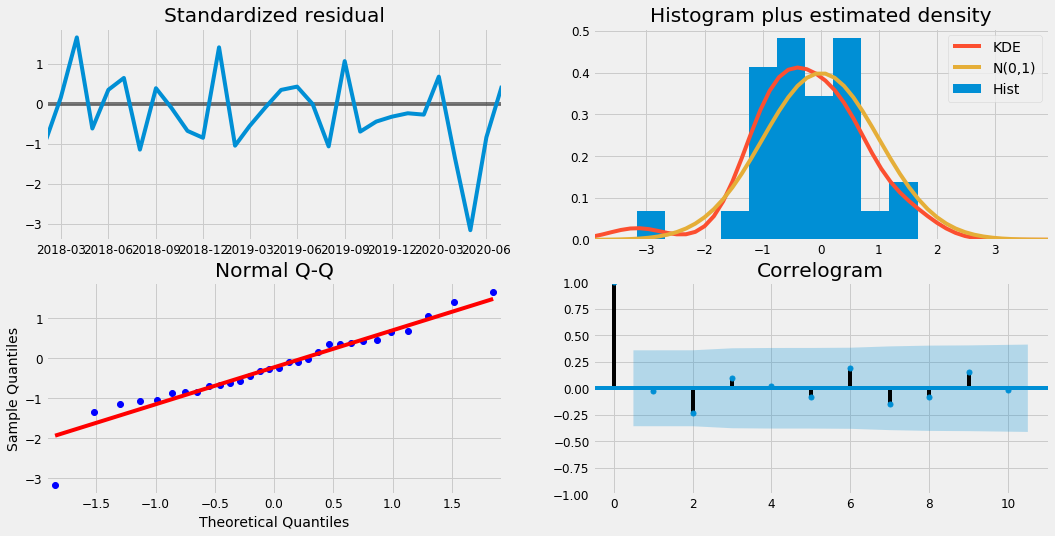

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Step: 11.1
Model in-sample Mean Absolute Percentage Error value

In [ ]:
true_test = true_test.reset_index()
true_test = true_test[[month_attr, revenue_attr]]
true_test = true_test.set_index([month_attr])
y_true = true_test[revenue_attr].values
pred_mean = pred.predicted_mean.to_frame()
pred_mean = pred_mean.reset_index()
pred_mean = pred_mean.iloc[:,1]
y_pred = pred_mean.values
mean_absolute_percentage_error(y_true, y_pred)
print('MAPE:{:.3f}%'.format(mean_absolute_percentage_error(y_true, y_pred)))

MAPE:7.533%


## Step: 11.2
Monthly out-sample prediction value of the revenue

In [ ]:
print("Forecast")
forecast = pred_uc.predicted_mean.to_frame()
forecast = forecast.reset_index()
forecast.head(20)

Forecast


,index,0
0,2020-08-01,2.815331e+07
1,2020-09-01,3.385134e+07
2,2020-10-01,3.789874e+07
3,2020-11-01,2.587185e+07
4,2020-12-01,2.658829e+07
5,2021-01-01,3.716891e+07
6,2021-02-01,2.724399e+07
7,2021-03-01,3.630444e+07
8,2021-04-01,3.158091e+07
9,2021-05-01,1.811037e+07


## Step: 11.3
Lower and Upper confidence value of the out-sample revenue predictions with 95% confidence.

In [ ]:
print("Pred Ci")
pred_ci.head(6)

Pred Ci


,lower BillingLegalNetPlanRateUSD,upper BillingLegalNetPlanRateUSD
2020-08-01,2.161542e+07,3.469119e+07
2020-09-01,2.687004e+07,4.083264e+07
2020-10-01,3.056512e+07,4.523236e+07
2020-11-01,1.820501e+07,3.353869e+07
2020-12-01,1.860226e+07,3.457432e+07
2021-01-01,2.887598e+07,4.546185e+07


## Step 12
Aggregating the predicted monthly revenue values to quarterly revenue values.

In [ ]:
# Aggregate into quarters.

In [ ]:
quarterly_forecast = convert_to_quarterly(forecast, 0, 'index')
quarterly_forecast.head(10)

,0
index,
2020-08-01,9.990338e+07
2020-11-01,8.962905e+07
2021-02-01,9.512934e+07
2021-05-01,7.621075e+07
2021-08-01,8.731911e+07
2021-11-01,4.207158e+07
